In [40]:
from skykatana import SkyMaskPipe

# How to swing a Skykatana

For an input catalog of HSC sources, this creates a pixelized mask or map in healsparse format, excluding areas due to various reasons such as bright stars, patches with low depth, etc. It also allows to combine this mask with arbitrary regions defined by the user\
\
Basic usage: 
* *build_footprint_mask(), build_patch_mask(), build_holes_mask()*, etc. are used to produce individual masks
* *combine_mask()* merges the maps create above to general a final mask
* *plot()* can quickly visualize a mask
* *makerans()* can generate randoms over a mask
* *apply()* can cut out sources outside of a given mask

Fixed/new features: 
* Added option to build_patch_mask() for custom filtering of HSC patches, e.g. filt='(imag_psf_depth>26.3) and (dec>10)'
* Option to add a mask due to extended (elliptical) sources
* Option to add a user defined mask (circle and quadpoly primitives)
* Stars/boxes of HSC are now in parquet format to speed up reading
* Fixed AND operation. Use intersect_boolmask() to perform intersection of arbitrary boolean masks 

Todo:
* Add healsparse as a possible format for user defined mask  
* Add logic to control missing arguments, masks not create, wrong types, etc.
* Change makerans() output to parquet

## Define inputs

In [60]:
# Input hipscatted catalog
HIPCAT = '../data/hscx_minispring_gal/'

# Bright star regions of HSC
STARS_REGIONS     = '../data/hsc_aux/stars.reg.I.nodups.parquet' 
BOX_STARS_REGIONS = '../data/hsc_aux/box.reg.I.parquet' 

# HSC patches and QA patch list ###################################### 
# Parquet patches are made by /hsc_patches/extract_patch_rects.ipynb
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = ['../data/hsc_aux/tracts_patches_W-spring.parquet']
QA_FILE       = '../data/hsc_aux/patch_qa.csv'

# Extended sources to mask out
ELLIP_REGIONS = '../data/hsc_aux/extended_sources.txt'

# User defined masks
USER_CIRCLE_REGIONS = '../data/hsc_aux/user_circs.txt' 
USER_POLY_REGIONS   = '../data/hsc_aux/user_polys.txt'

## Create the pipeline and run!
After SkyMaskPipe is instanciated, you can build masks (a.k.a. maps) due to various effects. Each of them is independent and can be run (or not) individually. Their results are healsparse maps stored within the class under:
* **SkyMaskPipe.foot**      :: holds the footprint map created from the input catalog
* **SkyMaskPipe.patchmap**  :: holds the map created from HSC patches matching some criteria
* **SkyMaskPipe.holemap**  :: holds the map created from bright stars and boxes around them in HSC, to mask out  
* **SkyMaskPipe.extendedmap**  :: holds the map created from a list of elliptical sources to mask out
* **SkyMaskPipe.usermap**  :: holds the footprint map created from the input catalog

Then, all/some of these masks can be combined into a final mask under **SkyMaskPipe.mask**    

In [64]:
mkp = SkyMaskPipe()
mkp.build_footprint_mask(hipcat=HIPCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS)
mkp.build_extended_mask(ellip_regs=ELLIP_REGIONS)
mkp.combine_mask()

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../data/hscx_minispring_gal/
    Order :: 13
--- Footprint map area                    : 65.03291193694062
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../data/hsc_aux/tracts_patches_W-spring.parquet
    Order :: 13
    Patches with QA                       : 29442
    Patches with QA fulfilling conditions : 16473
    Surviving patch pixels                : 8896590
--- Patch map area                        : 455.740445010328
BUILDING BRIGHT STAR HOLES MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../data/hsc_aux/stars.reg.I.nodups.parquet
    Order :: 15
    done
--- Pixelating boxes from ../data/hsc_aux/box.reg.I.parquet
    Order :: 15
    done
--- Holes map area                        : 286.00231471277164
BUILDING EXTENDED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating ellipses from ../data/hsc_aux/extended_sources.t

## Explore some plots

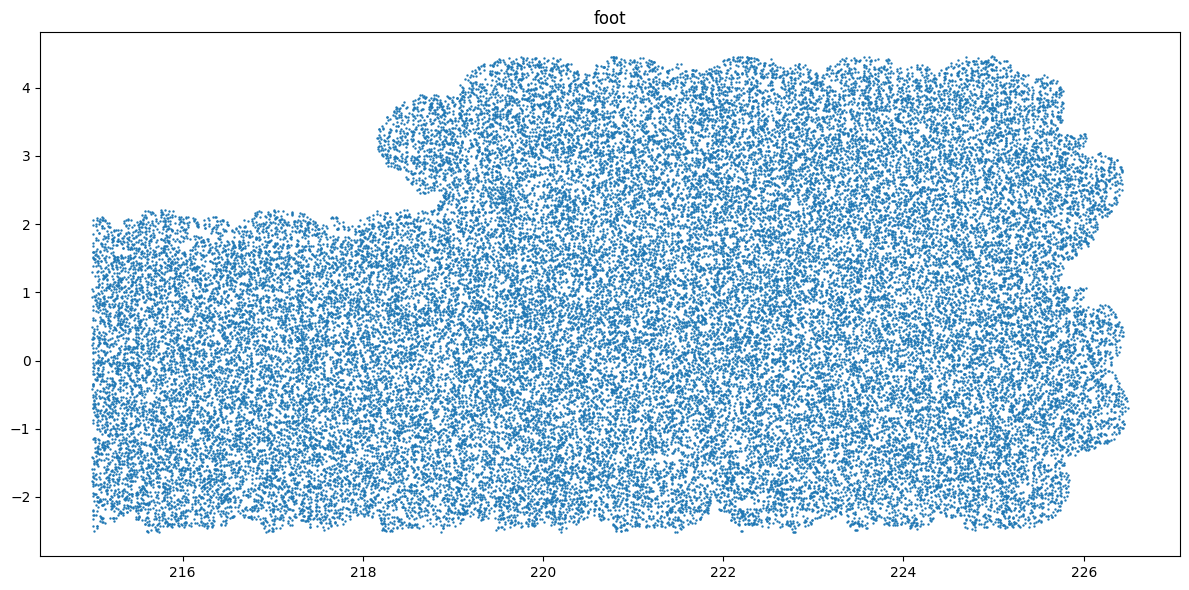

In [65]:
mkp.plot(stage='foot')

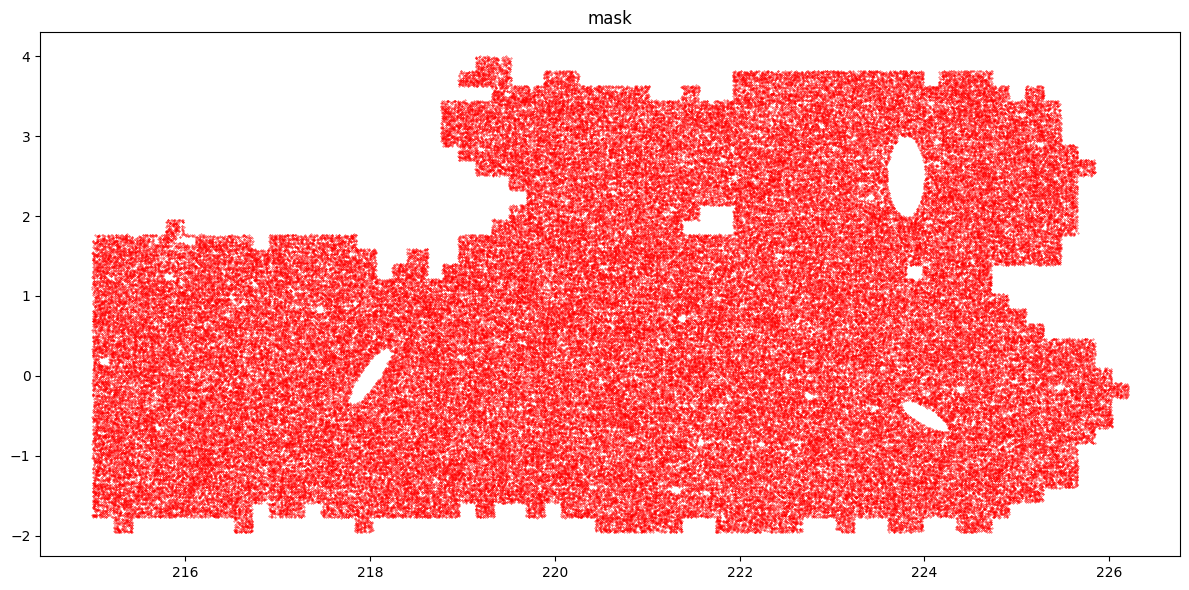

In [66]:
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r')

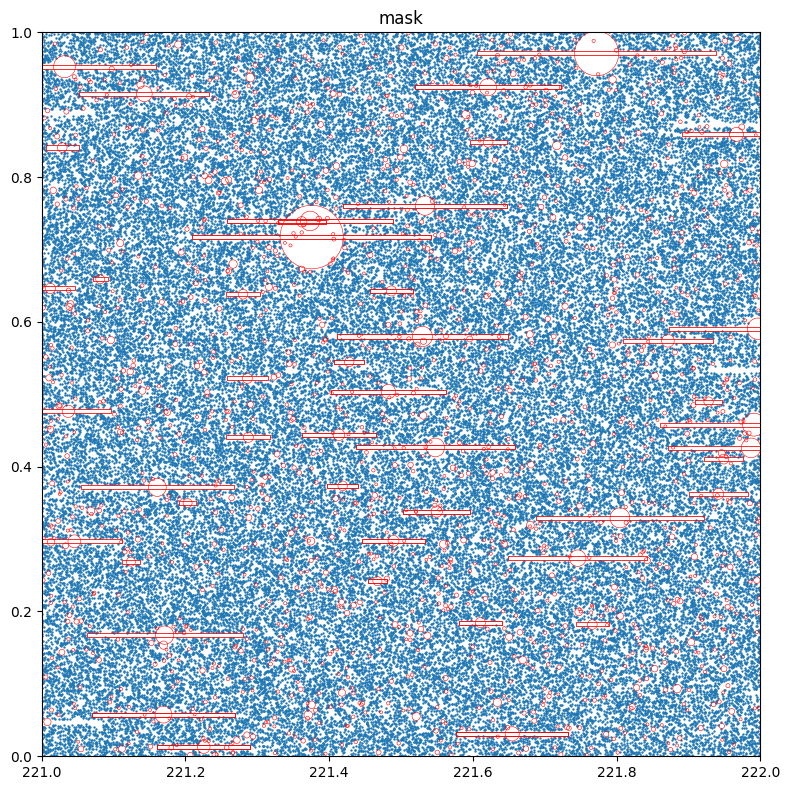

In [67]:
# Change figsize, zoom, overlay stars, overlay boxes
mkp.plot(stage='mask', nr=4_000_000, figsize=[8,8], xwin=[221,222], ywin=[0,1], plot_stars=True, plot_boxes=True)

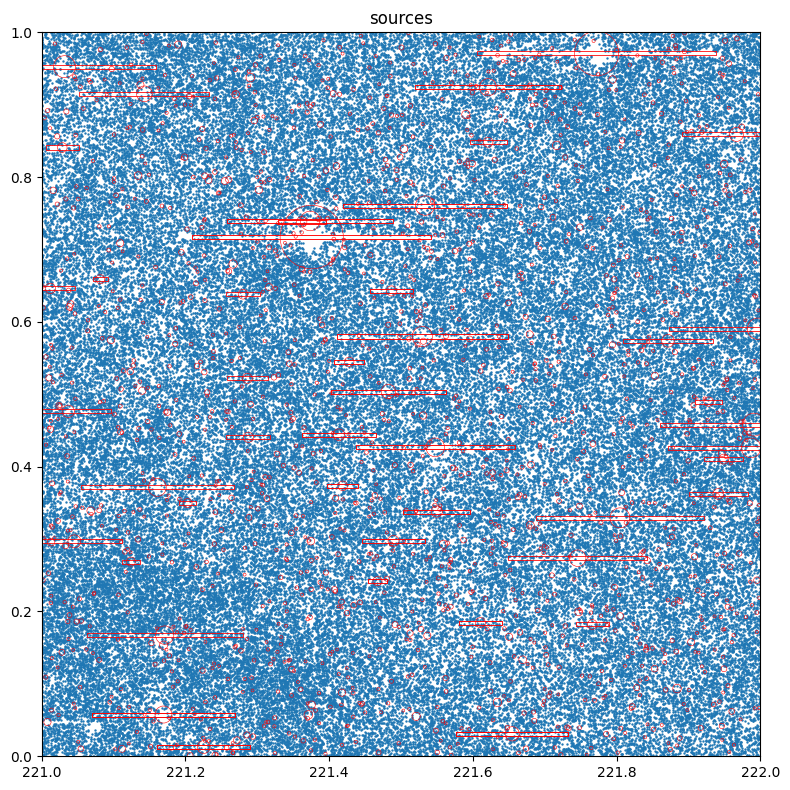

In [68]:
mkp.plot(stage='mask', nr=4_000_000, figsize=[8,8], xwin=[221,222], ywin=[0,1], plot_stars=True, plot_boxes=True, use_srcs=True)

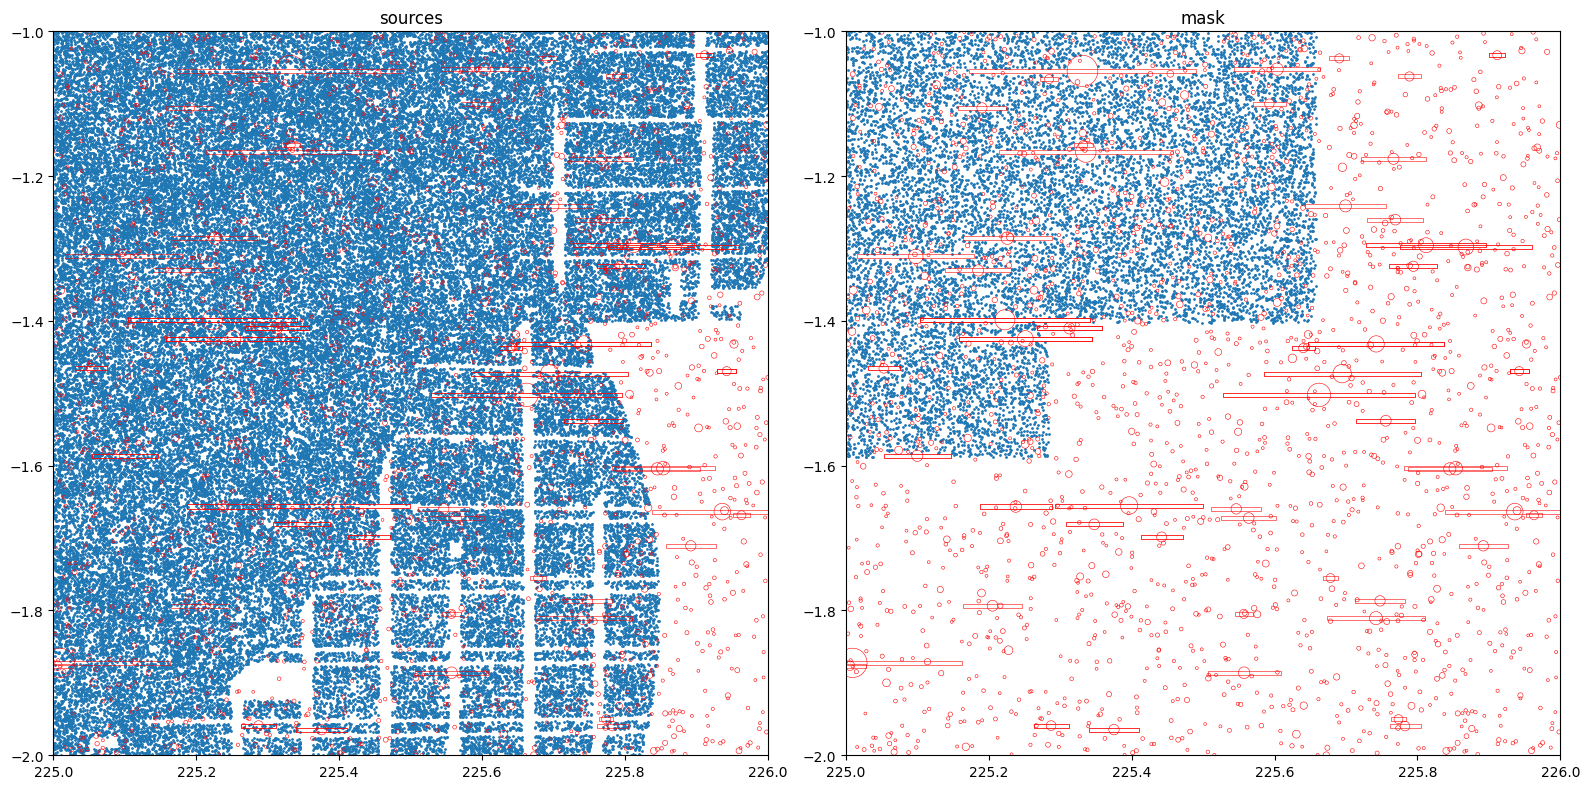

In [69]:
# Plot sources on the left, and randoms over the final mask on the right
mkp.plot2compare(stage='mask', nr=2_000_000, s=1, figsize=[16,8], xwin=[225,226], ywin=[-2,-1], 
                 plot_stars=True, plot_boxes=True)

## Generate randoms / Apply final mask to input catalog

In [70]:
rands = mkp.makerans(stage='mask', nr=500_000)
rands[0:10]

<Table length=10>
        ra                 dec        
     float64             float64      
------------------ -------------------
221.60304129123688  1.5658017482360902
219.37395930290222 -0.5078494283991385
 219.7356390953064 0.27437885458708383
223.99327576160428   2.132786500247646
215.22785425186157  0.9853944335925473
 224.0365719795227 -1.7495242862309843
222.99169600009915  0.9177252436729737
217.10898399353025  0.4062767168271623
224.99472141265866 -0.5179949425954448
225.14763951301572  2.5842221123043623

In [71]:
# Use apply() to return a catalog filtered by the mask
import lsdb
srcs = lsdb.read_hipscat(HIPCAT, columns=['ra_mag','dec_mag']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'])

5616316 sources within mask


## Now add a user-defined mask

In [72]:
mkp.build_user_mask(circ_uregs=USER_CIRCLE_REGIONS, poly_uregs=USER_POLY_REGIONS)
mkp.combine_mask(apply_extendedmap=False, apply_usermap=True)        # By default apply_usermap=False

BUILDING USER DEFINED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../data/hsc_aux/user_circs.txt
    Order :: 15
    done
--- Pixelating polygons from ../data/hsc_aux/user_polys.txt
    Order :: 15
--- User map area                         : 1.2559277140625398
COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 1.1014320366880248


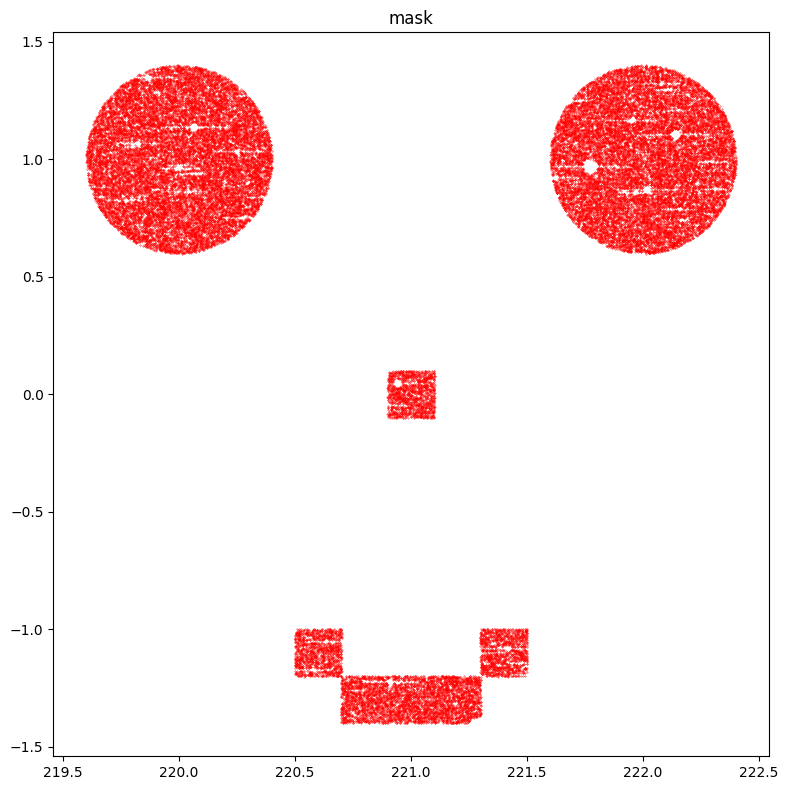

In [73]:
mkp.plot(stage='mask', nr=50_000, s=0.09, color='r', figsize=[8,8])

## Apply custom HSC patch filtering

In [74]:
mkp_custom = SkyMaskPipe()
mkp_custom.build_footprint_mask(hipcat=HIPCAT)
mkp_custom.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, filt='(imag_psf_depth>26.3)')
mkp_custom.combine_mask(apply_holemap=False, apply_extendedmap=False)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../data/hscx_minispring_gal/
    Order :: 13
--- Footprint map area                    : 65.03291193694062
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../data/hsc_aux/tracts_patches_W-spring.parquet
    Order :: 13
    Patches with QA                       : 29442
    Patches with QA fulfilling conditions : 9100
    Surviving patch pixels                : 5048107
--- Patch map area                        : 258.5964432034917
COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- footprint order upgraded to: 15
--- patchmap order upgraded to:  15
--- Combined map area                     : 27.95482021617621


In [80]:
# Recombine the final mask again without the usermap "face" above
mkp.combine_mask()    # By default apply_usermap=False

COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 42.83855053679152


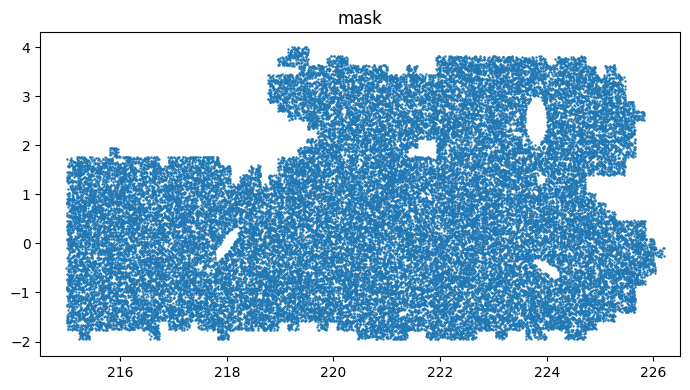

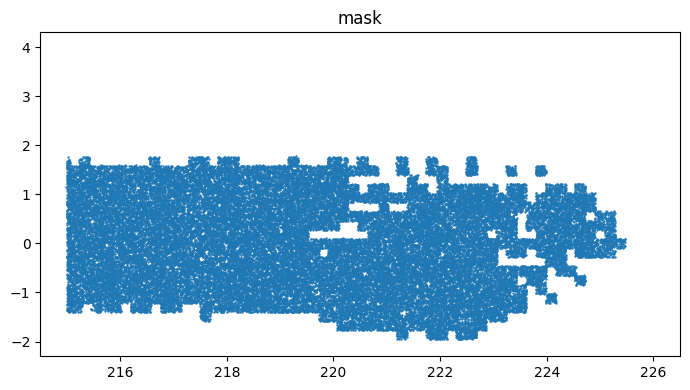

In [81]:
# Now compare the default filter applied before and the new i-band only patch filter
mkp.plot(stage='mask', figsize=[7,4], xwin=[214.5, 226.5], ywin=[-2.3, 4.3])
mkp_custom.plot(stage='mask', figsize=[7,4], xwin=[214.5, 226.5], ywin=[-2.3, 4.3])